# Hierarchical Clustering

## Autoreload

Autoreload allows the notebook to dynamically load code: if we update some helper functions *outside* of the notebook, we do not need to reload the notebook.

In [2]:
%load_ext autoreload
%autoreload 2

## Imports

In [3]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import procyclingstats as pcs
import umap

from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering


# Otherwise nothing will be found
sys.path.append(os.path.abspath(os.path.join('..')))

c:\Users\Yuri\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports from our utilities:

In [4]:
from utility.overall_utilities import save_plot

Global variables, constants, etc.

In [5]:
sys.path.append('../dataset/')
sys.path.append('../utility/')

# Global variables, constants
IMAGE_DIR = '../images/'
RANDOM_STATE = 42   # we define a random state to make the results reproducible
RUN_SLOW_STUFF = True

## Dataframes

We've spent a lot of effort into engineering new features, understanding them, etc. Whether we've done this well and whether is enough it's a different story.

The point here is that - after the understanding, engineering and transformation - we have some cleaned-up versions of the datasets.

In [6]:
cyclists_df = pd.read_csv('../dataset/cyclists_cleaned.csv')
races_df = pd.read_csv('../dataset/races_cleaned.csv')

In [7]:
cyclists_df.columns

Index(['_url', 'name', 'birth_year', 'weight', 'height', 'nationality', 'bmi',
       'race_count', 'experience_level', 'total_points', 'victories_by_points',
       'average_position', 'cyclist_age', 'avg_points_per_race',
       'avg_speed_cyclist', 'cyclist', 'stamina_index'],
      dtype='object')

In [8]:
races_df.columns

Index(['_url', 'name', 'stage', 'stage_type', 'points', 'uci_points', 'length',
       'climb_total', 'profile', 'startlist_quality', 'date', 'position',
       'cyclist', 'cyclist_age', 'is_tarmac', 'delta', 'time', 'time_seconds',
       'average_speed', 'steepness', 'season', 'is_staged', 'race_country',
       'norm_points', 'age_performance_index', 'quality_adjusted_points',
       'normalized_length', 'normalized_quality', 'normalized_steepness',
       'normalized_time', 'stamina_index', 'season_name', 'length_category'],
      dtype='object')

Now, that's *a lot* of features. Too many. Some features will be selected for the clustering. The selection of the candidate features should be guided by both the analysis of the interrelations among features (e.g. correlation), and by intuition (or, better, the will to test a "working hypothesis"). Both things come from understanding. That is, have a good grasp on the data.

In [9]:
cyclists_df = cyclists_df.select_dtypes(include=[np.number])

In [10]:
cyclists_df = cyclists_df.drop(columns=['birth_year', 'weight', 'height', 'race_count', 'total_points'])

In [11]:
cyclists_df = cyclists_df.dropna()
cyclists_df.describe()

,bmi,victories_by_points,average_position,cyclist_age,avg_points_per_race,avg_speed_cyclist,stamina_index
count,2907.000000,2907.000000,2907.000000,2907.000000,2907.000000,2907.000000,2907.000000
mean,21.177112,0.313037,84.572488,39.898865,3.195988,11.001298,7.575981
std,1.360469,1.591782,26.455929,11.697528,6.829704,0.322513,2.249219
min,16.412069,0.000000,3.000000,20.000000,0.000000,9.562050,0.303011
25%,20.286508,0.000000,68.000000,31.000000,0.448620,10.836965,6.636310
50%,21.132713,0.000000,84.842857,38.000000,1.224490,10.983977,7.094253
75%,22.038401,0.000000,101.473999,47.000000,3.420070,11.142460,7.908122
max,27.770313,29.000000,205.000000,84.000000,150.000000,13.021981,70.167143


In [12]:
data_dist = pdist(cyclists_df, metric='euclidean')

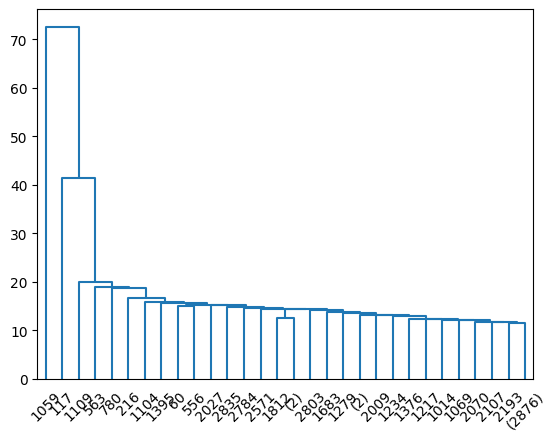

In [13]:
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, color_threshold=10, truncate_mode='lastp')

In [32]:
single_linkage = AgglomerativeClustering(n_clusters=6, metric='euclidean', linkage='average')

In [33]:
single_linkage.fit_predict(cyclists_df)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [34]:
labels_full = single_linkage.labels_

In [28]:
reducer = umap.UMAP(n_neighbors=15, learning_rate=0.1, n_components=3, random_state=RANDOM_STATE)

In [29]:
reduced_data = reducer.fit_transform(cyclists_df)

c:\Users\Yuri\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [35]:
import plotly.express as px
import pandas as pd

# Prepare data for Plotly
df = pd.DataFrame({
    'UMAP 1': reduced_data[:, 0],
    'UMAP 2': reduced_data[:, 1],
    'UMAP 3': reduced_data[:, 2],
    'Cluster': labels_full
})

# Create interactive 3D scatter plot
fig = px.scatter_3d(
    df,
    x='UMAP 1',
    y='UMAP 2',
    z='UMAP 3',
    color='Cluster',
    title='UMAP 3D',
    color_continuous_scale='Viridis'
)

# Show the interactive plot
fig.show()


In [37]:
single_linkage.fit_predict(reduced_data)

array([0, 1, 1, ..., 1, 4, 1], dtype=int64)

In [38]:
import plotly.express as px
import pandas as pd

# Prepare data for Plotly
df = pd.DataFrame({
    'UMAP 1': reduced_data[:, 0],
    'UMAP 2': reduced_data[:, 1],
    'UMAP 3': reduced_data[:, 2],
    'Cluster': single_linkage.labels_
})

# Create interactive 3D scatter plot
fig = px.scatter_3d(
    df,
    x='UMAP 1',
    y='UMAP 2',
    z='UMAP 3',
    color='Cluster',
    title='UMAP 3D',
    color_continuous_scale='Viridis'
)

# Show the interactive plot
fig.show()


In [41]:
# apply labels to the cyclists dataframe
#  cyclists_df['cluster'] = single_linkage.labels_
cyclists_df['cluster'] = labels_full

In [48]:
cyclists_df.groupby('cluster').mean()

,bmi,victories_by_points,average_position,cyclist_age,avg_points_per_race,avg_speed_cyclist,stamina_index
cluster,,,,,,,
0,23.178488,7.000000,8.144070,77.285714,74.418421,10.927001,29.978223
1,21.141501,0.210526,84.366642,39.025945,2.351538,11.008394,7.365074
2,21.156879,0.000000,145.297458,35.555556,2.101867,10.987219,7.442729
3,22.093170,0.000000,3.000000,81.000000,150.000000,11.503743,25.047306
4,22.083346,2.886364,26.469212,69.329545,21.324537,10.763044,11.805288
5,21.895023,7.800000,29.919076,26.200000,34.359570,11.673552,14.966487
